# 사전작업

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [4]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

## 데이터 로드

In [5]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 3min 13s


## train, test 합치기

In [6]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194747

## DROP TIME RELATED FEATURE

In [7]:
DROP_FEATURES__ = ['EngineVersion', 'AppVersion', 'AvSigVersion', 
                   'OsVer', 'OsBuild', 'OsPlatformSubRelease', 'OsBuildLab', 
                   'IeVerIdentifier',
                   'Census_OSVersion', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_FirmwareVersionIdentifier']

In [8]:
data = data.drop(DROP_FEATURES__, axis=1)

In [9]:
data.head(1)

,MachineIdentifier,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,win8defender,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,256,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.90625,1440.0,900.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.0


In [1]:
# categorical feature (dummy)

DROP_FEATURES = ['IsBeta', 'AutoSampleOptIn', 'Census_ProcessorClass', 'Census_OSArchitecture']

# binary not null
BINARY_FEATURES = ['IsSxsPassiveMode', 'HasTpm', 'IsProtected', 'Census_HasOpticalDiskDrive', 'Census_IsPortableOperatingSystem',
                   'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsPenCapable']

# 그냥 쓸 수 있는 피처
NORMALFEATURES = ['AVProductsInstalled', 'AVProductsEnabled', 'AVProductsEnabled', 'Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']

# contains binary with null
FEATURES_DUMMY_ENCODING = ['ProductName', 'RtpStateBitfield', 'Platform', 'Processor', 'SkuEdition', 'PuaMode', 'SMode', 
                           'SmartScreen', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor', 'Census_DeviceFamily', ''
                           'Census_ProcessorManufacturerIdentifier', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName',
                           'Census_PowerPlatformRoleName', 'Census_OSArchitecture', 'Census_OSEdition', 'Census_OSSkuName',
                           'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
                           'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel',
                           'Census_IsFlightingInternal', 'Census_IsFlightsDisabled', 'Census_FlightRing', 'Census_ThresholdOptIn',
                           'Census_IsWIMBootEnabled', 'Census_IsVirtualDevice']

FEATURES_FREQ_ENCODING = ['DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'CountryIdentifier', 'CityIdentifier', 
                         'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsSuite', 
                         'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier',
                         'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 'Wdft_RegionIdentifier']

FEATURES_NO_IDEA = ['Census_InternalPrimaryDiagonalDisplaySizeInInches', 
                    'Census_InternalPrimaryDisplayResolutionHorizontal',
                    'Census_InternalPrimaryDisplayResolutionVertical',
                    'Census_InternalBatteryType', 'Census_InternalBatteryNumberOfCharges',
                    'Census_FirmwareManufacturerIdentifier']

## Train, Test split

In [12]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]
# del data
# gc.collect()

In [13]:
train.MachineIdentifier = range(len(train))
train.reset_index(drop=True, inplace=True)

test.MachineIdentifier = range(len(test))
test.reset_index(drop=True, inplace=True)

In [14]:
debug = False
if debug:
    train = train[:10000]
    test = test[:10000]

## Meta

In [15]:
meta = data[['MachineIdentifier', 'HasDetections']]

## Feature Engineering

In [16]:
data.head(1)

,MachineIdentifier,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,win8defender,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,256,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.90625,1440.0,900.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.0


### 기타 피처

#### RtpStateBitfield

* 35 => 8
* one-hot encoding

In [17]:
data.RtpStateBitfield.replace(35, 8, inplace=True)
data.RtpStateBitfield.fillna('null', inplace=True)

In [18]:
cols = 'RtpStateBitfield'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [19]:
meta = pd.concat([meta, dummy], axis=1)

#### ProductName
* win8defender와 그 외
* win8defender => 1
* 그 외 => 0

In [20]:
meta['ProductName_IsWin8Defender'] = (data.ProductName == 'win8defender') * 1

#### IsSxsPassiveMode

In [21]:
meta['IsSxsPassiveMode'] = data.IsSxsPassiveMode

#### HasTpm

In [22]:
meta['HasTpm'] = data.HasTpm

#### Platform
* one-hot encoding

In [23]:
cols = 'Platform'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [24]:
meta = pd.concat([meta, dummy], axis=1)

#### Processor
* one-hot encoding

In [25]:
cols = 'Processor'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [26]:
meta = pd.concat([meta, dummy], axis=1)

#### SkuEdition
* one-hot encoding

In [27]:
cols = 'SkuEdition'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [28]:
meta = pd.concat([meta, dummy], axis=1)

#### PuaMode
* Is PuaMode On ?

In [29]:
meta['PuaMode_IsOn'] = (data.PuaMode == "on") * 1

#### SMode
* Is SMode 1 ?
* Is SMode nan ?

In [30]:
meta['SMode_Is_1'] = (data.SMode == 1) * 1

In [31]:
meta['SMode_IsNull'] = (data.SMode.isna()) * 1

#### SmartScreen
* one-hot encoding

In [32]:
# Preprocessing
data.SmartScreen.replace('RequiredAdmin', 'RequireAdmin', inplace=True)
data.SmartScreen.replace('requireadmin', 'RequireAdmin', inplace=True)
data.SmartScreen.replace('requireAdmin', 'RequireAdmin', inplace=True)
data.SmartScreen.replace('on', 'On', inplace=True)
data.SmartScreen.replace('ON', 'On', inplace=True)
data.SmartScreen.replace('ON', 'On', inplace=True)
data.SmartScreen.replace('BLOCK', 'Block', inplace=True)
data.SmartScreen.replace('Promt', 'Prompt', inplace=True)
data.SmartScreen.replace('Promprt', 'Prompt', inplace=True)
data.SmartScreen.replace('prompt', 'Prompt', inplace=True)
data.SmartScreen.replace('warn', 'Warn', inplace=True)
data.SmartScreen.replace('OFF', 'off', inplace=True)
data.SmartScreen.replace('of', 'off', inplace=True)

# etc
data.SmartScreen.replace('&#x02;', 'ETC', inplace=True)
data.SmartScreen.replace('&#x01;', 'ETC', inplace=True)
data.SmartScreen.replace('0', 'ETC', inplace=True)
data.SmartScreen.replace('&#x03;', 'ETC', inplace=True)
data.SmartScreen.replace('Deny', 'ETC', inplace=True)
data.SmartScreen.replace('00000000', 'ETC', inplace=True)
data.SmartScreen.replace('Enabled', 'ETC', inplace=True)

In [33]:
cols = 'SmartScreen'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [34]:
meta = pd.concat([meta, dummy], axis=1)

#### Firewall

In [35]:
data.Firewall.fillna(-999, inplace=True)

In [36]:
meta['Firewall'] = data.Firewall

#### UacLuaenable

In [37]:
data.loc[(data.UacLuaenable != 1) & (data.UacLuaenable != 0), 'UacLuaenable'] = -999

In [38]:
meta['UacLuaenable'] = data.UacLuaenable

#### Census_MDC2FormFactor

In [39]:
data.Census_MDC2FormFactor.value_counts()

Notebook        10652855
Desktop          3813472
Convertible       744141
AllInOne          547632
Detachable        544171
PCOther           275408
LargeTablet       121325
SmallTablet        52491
SmallServer        15563
MediumServer        6169
LargeServer         1453
ServerOther           53
IoTOther               2
Other                  1
Name: Census_MDC2FormFactor, dtype: int64

In [40]:
# data.Census_MDC2FormFactor.replace('SmallServer', 'Server', inplace=True)
# data.Census_MDC2FormFactor.replace('MediumServer', 'Server', inplace=True)
# data.Census_MDC2FormFactor.replace('LargeServer', 'Server', inplace=True)
# data.Census_MDC2FormFactor.replace('ServerOther', 'Server', inplace=True)
# data.Census_MDC2FormFactor.replace('LargeTablet', 'Tablet', inplace=True)
# data.Census_MDC2FormFactor.replace('SmallTablet', 'Tablet', inplace=True)
# data.Census_MDC2FormFactor.replace('PCOther', 'Desktop', inplace=True)
data.Census_MDC2FormFactor.replace('IoTOther', 'Notebook', inplace=True)
data.Census_MDC2FormFactor.replace('Other', 'Notebook', inplace=True)

In [41]:
cols = 'Census_MDC2FormFactor'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [42]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_DeviceFamily

In [43]:
data.Census_DeviceFamily.replace('Windows', 'Windows.Desktop', inplace=True)

In [44]:
meta['Census_DeviceFamily_IsServer'] = (data.Census_DeviceFamily == 'Windows.Server') * 1

#### Census_ProcessorManufacturerIdentifier
* 인텔이냐? 암드냐? 그외냐? 널이냐?

In [45]:
meta['Census_ProcessorManufacturerIdentifier_Is_5'] = (data.Census_ProcessorManufacturerIdentifier == 5) * 1

In [46]:
meta['Census_ProcessorManufacturerIdentifier_Is_1'] = (data.Census_ProcessorManufacturerIdentifier == 1) * 1

In [47]:
meta['Census_ProcessorManufacturerIdentifier_Is_nor_5_1'] = ((data.Census_ProcessorManufacturerIdentifier != 5) & (data.Census_ProcessorManufacturerIdentifier != 1) & ~(data.Census_ProcessorManufacturerIdentifier.isna())) * 1

In [48]:
meta['Census_ProcessorManufacturerIdentifier_IsNull'] = (data.Census_ProcessorManufacturerIdentifier.isna()) * 1

#### Census_ProcessorClass

In [49]:
meta['Census_ProcessorClass_mid'] = (data.Census_ProcessorClass == 'mid') * 1
meta['Census_ProcessorClass_low'] = (data.Census_ProcessorClass == 'low') * 1
meta['Census_ProcessorClass_high'] = (data.Census_ProcessorClass == 'high') * 1

#### Census_PrimaryDiskTypeName

In [50]:
data.Census_PrimaryDiskTypeName.fillna('UNKNOWN', inplace=True)

In [51]:
cols = 'Census_PrimaryDiskTypeName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [52]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_HasOpticalDiskDrive

In [53]:
meta['Census_HasOpticalDiskDrive'] = data.Census_HasOpticalDiskDrive

#### Census_ChassisTypeName

In [54]:
data.Census_ChassisTypeName.replace('39', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('28', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('49', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('64', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('83', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('76', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('93', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('120', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('82', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('112', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('45', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('81', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('36', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('44', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('25', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('32', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('127', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('88', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('31', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('35', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('0', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('30', 'UNKNOWN',inplace=True)
data.Census_ChassisTypeName.replace('Unknown', 'UNKNOWN', inplace=True)
data.Census_ChassisTypeName.replace('PeripheralChassis', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('EmbeddedPC', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('IoTGateway', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('CompactPCI', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('BladeEnclosure', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('DockingStation', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('Blade', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('SealedCasePC', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('StickPC', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('SubChassis', 'Other', inplace=True)
data.Census_ChassisTypeName.replace('MultisystemChassis', 'Other',inplace=True)
data.Census_ChassisTypeName.replace('PizzaBox', 'LunchBox',inplace=True)
data.Census_ChassisTypeName.replace('SubNotebook', 'Notebook', inplace=True)
data.Census_ChassisTypeName.replace('BusExpansionChassis', 'ExpansionChassis', inplace=True)

In [55]:
cols = 'Census_ChassisTypeName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [56]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_PowerPlatformRoleName

In [57]:
data.Census_PowerPlatformRoleName.value_counts()

Mobile               11506825
Desktop               4028639
Slate                  895497
Workstation            210952
SOHOServer              72634
UNKNOWN                 39110
EnterpriseServer        13617
AppliancePC              7190
PerformanceServer         172
Unspecified                19
Name: Census_PowerPlatformRoleName, dtype: int64

In [58]:
data.Census_PowerPlatformRoleName.replace('Unspecified', 'UNKNOWN',inplace=True)
data.Census_PowerPlatformRoleName.fillna('UNKNOWN', inplace=True)

In [59]:
cols = 'Census_PowerPlatformRoleName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [60]:
dummy.drop(['Census_PowerPlatformRoleName_Unspecified'], axis=1, inplace=True)

In [61]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_OSInstallTypeName

In [62]:
cols = 'Census_OSInstallTypeName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [63]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_OSWUAutoUpdateOptionsName

In [64]:
cols = 'Census_OSWUAutoUpdateOptionsName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [65]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_IsPortableOperatingSystem

In [66]:
meta['Census_IsPortableOperatingSystem'] = data.Census_IsPortableOperatingSystem

#### Census_GenuineStateName

In [67]:
data.Census_GenuineStateName.replace('TAMPERED', 'UNKNOWN', inplace=True)

In [68]:
cols = 'Census_GenuineStateName'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [69]:
dummy.drop(['Census_GenuineStateName_TAMPERED'], axis=1, inplace=True)

In [70]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_ActivationChannel

In [71]:
cols = 'Census_ActivationChannel'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [72]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_IsFlightingInternal

In [73]:
data.Census_IsFlightingInternal.fillna(-999, inplace=True)

In [74]:
meta['Census_IsFlightingInternal'] = data.Census_IsFlightingInternal

#### Census_IsFlightsDisabled

In [75]:
data.Census_IsFlightsDisabled.fillna(-999, inplace=True)

In [76]:
meta['Census_IsFlightsDisabled'] = data.Census_IsFlightsDisabled

#### Census_FlightRing

In [77]:
data.Census_FlightRing.replace('Invalid', 'Unknown', inplace=True)
data.Census_FlightRing.replace('Canary', 'Unknown', inplace=True)
data.Census_FlightRing.replace('OSG', 'Unknown', inplace=True)
data.Census_FlightRing.replace('CBCanary', 'Unknown', inplace=True)

In [78]:
cols = 'Census_FlightRing'
dummy = pd.get_dummies(data[cols])
dummy.columns = [cols + '_' + str(v) for v in dummy.columns]

In [79]:
meta = pd.concat([meta, dummy], axis=1)

#### Census_ThresholdOptIn

In [80]:
data.Census_ThresholdOptIn.fillna(-999, inplace=True)

In [81]:
meta['Census_ThresholdOptIn'] = data.Census_ThresholdOptIn

#### Census_IsSecureBootEnabled

In [82]:
meta['Census_IsSecureBootEnabled'] = data.Census_IsSecureBootEnabled

#### Census_IsWIMBootEnabled

In [83]:
data.Census_IsWIMBootEnabled.fillna(1, inplace=True)

In [84]:
meta['Census_IsWIMBootEnabled'] = data.Census_IsWIMBootEnabled

#### Census_IsVirtualDevice

In [85]:
data.Census_IsVirtualDevice.fillna(-999, inplace=True)

In [86]:
meta['Census_IsVirtualDevice'] = data.Census_IsVirtualDevice

#### Census_IsTouchEnabled

In [87]:
meta['Census_IsTouchEnabled'] = data.Census_IsTouchEnabled

#### Census_IsPenCapable

In [88]:
meta['Census_IsPenCapable'] = data.Census_IsPenCapable

#### Census_IsAlwaysOnAlwaysConnectedCapable

In [89]:
data.Census_IsAlwaysOnAlwaysConnectedCapable.fillna(-999, inplace=True)

In [90]:
meta['Census_IsAlwaysOnAlwaysConnectedCapable'] = data.Census_IsAlwaysOnAlwaysConnectedCapable

#### Wdft_IsGamer

In [91]:
data.Wdft_IsGamer.fillna(-999, inplace=True)

In [92]:
meta['Wdft_IsGamer'] = data.Census_IsAlwaysOnAlwaysConnectedCapable

### label 많은 피처

#### TRAIN TEST 다른 비율 줄이기

In [94]:
temp = pd.read_csv('./data_temp/new_feature_region.csv')

In [97]:
for v in temp.columns:
    data[v] = temp[v]

In [98]:
del temp
gc.collect()

7871

In [99]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]
del data
gc.collect()

0

In [100]:
train.head(2)

,MachineIdentifier,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CityIdx_CountryIdx_multi,CityCnt_Per_Country,CityCnt_Per_Country_Minmax,CityCnt_Per_Country_Log,DataCnt_Per_Country,DataCnt_Per_Country_Minmax,DataCnt_Per_Country_Log,Personal_User,NewOrganizationIdentifier
0,0000028988387b115f69f31a3bf04f09,win8defender,0,7,0,NaN,53447.0,1.0,1.0,1,29.0,128035.0,18.0,35.0,-85,windows10,x64,256,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,-999.0,0.0,Retail,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,10.0,0.0,0,5257,3,9,645836,8,13,0,15795.0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,0,7,0,NaN,53447.0,1.0,1.0,1,93.0,1482.0,18.0,119.0,64,windows10,x64,256,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2404.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,amd64,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,-999.0,0.0,NOT_SET,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,8.0,0.0,0,3227,2,8,523673,6,13,0,87501.0


In [101]:
col_large_label = ['DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsSuite', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier', 'NewOrganizationIdentifier']

In [104]:
for usecol in tqdm_notebook(col_large_label):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] >= 1)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.3) & (agg['Train'] / agg['Total'] < 0.7)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

In [110]:
data

,MachineIdentifier,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CityIdx_CountryIdx_multi,CityCnt_Per_Country,CityCnt_Per_Country_Minmax,CityCnt_Per_Country_Log,DataCnt_Per_Country,DataCnt_Per_Country_Minmax,DataCnt_Per_Country_Log,Personal_User,NewOrganizationIdentifier
0,0,win8defender,0,7,0,2178.0,26978.0,1.0,1.0,1,145.0,24112.0,10.0,226.0,112.0,windows10,x64,4.0,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1231.0,227007.0,4.0,5.0,1190.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,-999.0,0.0,Retail,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,10.0,0.0,0,5257,3,9,645836,8,13,0,64391.0
1,1,win8defender,0,7,0,2178.0,26978.0,1.0,1.0,1,216.0,41795.0,10.0,23.0,216.0,windows10,x64,4.0,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1231.0,227346.0,4.0,5.0,0.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,amd64,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,-999.0,0.0,NOT_SET,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,8.0,0.0,0,3227,2,8,523673,6,13,0,148374.0
2,2,win8defender,0,7,0,2178.0,26978.0,1.0,1.0,1,208.0,46444.0,10.0,257.0,199.0,windows10,x64,13.0,Home,1.0,0,NaN,0.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,2230.0,162982.0,4.0,5.0,955.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,amd64,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,-999.0,0.0,Retail,-999.0,142.0,0,1.0,0.0,0,0,0.0,0.0,3.0,0.0,0,398,0,6,76200,1,11,0,144392.0
3,3,win8defender,0,7,0,2178.0,26978.0,1.0,1.0,1,210.0,62100.0,52.0,21.0,147.0,windows10,x64,4.0,Pro,1.0,0,NaN,0.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,397.0,131543.0,4.0,5.0,1151.0,NaN,238475.0,UNKNOWN,227116.0,0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,-999.0,0.0,Retail,-999.0,355.0,0,1.0,0.0,0,0,0.0,0.0,3.0,1.0,1,1557,1,7,166379,2,12,1,162259.0
4,4,win8defender,0,7,0,2178.0,26978.0,1.0,1.0,1,90.0,76743.0,52.0,198.0,228.0,windows10,x64,13.0,Home,1.0,0,NaN,0.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,397.0,175475.0,4.0,5.0,1278.0,NaN,476940.0,HDD,101900.0,0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,amd64,Core,CORE,Update,8.0,31,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,355.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1.0,

In [105]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

98

In [106]:
data.head(3)

,MachineIdentifier,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CityIdx_CountryIdx_multi,CityCnt_Per_Country,CityCnt_Per_Country_Minmax,CityCnt_Per_Country_Log,DataCnt_Per_Country,DataCnt_Per_Country_Minmax,DataCnt_Per_Country_Log,Personal_User,NewOrganizationIdentifier
0,0,win8defender,0,7,0,2178,26978,1.0,1.0,1,145,24112,10,226,112,windows10,x64,4,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1231,227007,4.0,5.0,1190,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,amd64,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,-999.0,0.0,Retail,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,10.0,0.0,0,5257,3,9,645836,8,13,0,64391
1,1,win8defender,0,7,0,2178,26978,1.0,1.0,1,216,41795,10,23,216,windows10,x64,4,Pro,1.0,0,NaN,0.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1231,227346,4.0,5.0,0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,amd64,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,-999.0,0.0,NOT_SET,-999.0,628.0,0,1.0,0.0,0,0,0.0,0.0,8.0,0.0,0,3227,2,8,523673,6,13,0,148374
2,2,win8defender,0,7,0,2178,26978,1.0,1.0,1,208,46444,10,257,199,windows10,x64,13,Home,1.0,0,NaN,0.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,2230,162982,4.0,5.0,955,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,amd64,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,-999.0,0.0,Retail,-999.0,142.0,0,1.0,0.0,0,0,0.0,0.0,3.0,0.0,0,398,0,6,76200,1,11,0,144392


In [108]:
for col in col_large_label:
    data[col] = data[col].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

#### DefaultBrowsersIdentifier
* count encoding

In [107]:
meta['DefaultBrowsersIdentifier'] = data.DefaultBrowsersIdentifier.map(data.DefaultBrowsersIdentifier.value_counts(dropna=False))

KeyboardInterrupt: 

#### AVProductStatesIdentifier
* count encoding

In [98]:
meta['AVProductStatesIdentifier'] = data.AVProductStatesIdentifier.map(data.AVProductStatesIdentifier.value_counts(dropna=False))

#### CountryIdentifier

In [99]:
meta['CountryIdentifier'] = data.CountryIdentifier.map(data.CountryIdentifier.value_counts(dropna=False))

#### CityIdentifier

In [100]:
meta['CityIdentifier'] = data.CityIdentifier.map(data.CityIdentifier.value_counts(dropna=False))

#### OrganizationIdentifier

In [101]:
meta['OrganizationIdentifier'] = data.OrganizationIdentifier.map(data.OrganizationIdentifier.value_counts(dropna=False))

#### GeoNameIdentifier

In [102]:
meta['GeoNameIdentifier'] = data.GeoNameIdentifier.map(data.GeoNameIdentifier.value_counts(dropna=False))

#### LocaleEnglishNameIdentifier

In [103]:
meta['LocaleEnglishNameIdentifier'] = data.LocaleEnglishNameIdentifier.map(data.LocaleEnglishNameIdentifier.value_counts(dropna=False))

#### OsSuite

In [104]:
meta['OsSuite'] = data.OsSuite.map(data.OsSuite.value_counts(dropna=False))

#### Census_OEMNameIdentifier

In [105]:
meta['Census_OEMNameIdentifier'] = data.Census_OEMNameIdentifier.map(data.Census_OEMNameIdentifier.value_counts(dropna=False))

#### Census_OEMModelIdentifier

In [106]:
meta['Census_OEMModelIdentifier'] = data.Census_OEMModelIdentifier.map(data.Census_OEMModelIdentifier.value_counts(dropna=False))

#### Census_ProcessorCoreCount

In [107]:
meta['Census_ProcessorCoreCount'] = data.Census_ProcessorCoreCount

#### Census_ProcessorModelIdentifier

In [108]:
meta['Census_ProcessorModelIdentifier'] = data.Census_ProcessorModelIdentifier.map(data.Census_ProcessorModelIdentifier.value_counts(dropna=False))

#### Census_SystemVolumeTotalCapacity and Census_PrimaryDiskTotalCapacity
* 시스템 / 디스크
* 시스템 / 디스크가 1이상인가?

In [109]:
meta['Census_PrimaryDiskTotalCapacity'] = data.Census_PrimaryDiskTotalCapacity.map(data.Census_PrimaryDiskTotalCapacity.value_counts(dropna=False))
meta['Census_SystemVolumeTotalCapacity'] = data.Census_SystemVolumeTotalCapacity.map(data.Census_SystemVolumeTotalCapacity.value_counts(dropna=False))

In [110]:
meta['PrimaryDisk_SystemVolume_rate'] = meta['Census_SystemVolumeTotalCapacity'] / meta['Census_PrimaryDiskTotalCapacity']

In [111]:
meta['PrimaryDisk_SystemVolume_rate_moreThan_1'] = (meta.PrimaryDisk_SystemVolume_rate >= 1) * 1

#### Census_TotalPhysicalRAM

In [112]:
meta['Census_TotalPhysicalRAM'] = data.Census_TotalPhysicalRAM.map(data.Census_TotalPhysicalRAM.value_counts(dropna=False))

In [113]:
data.Census_TotalPhysicalRAM = np.around((data.Census_TotalPhysicalRAM / 1024))

#### Census_OSInstallLanguageIdentifier

In [114]:
meta['Census_OSInstallLanguageIdentifier'] = data.Census_OSInstallLanguageIdentifier.map(data.Census_OSInstallLanguageIdentifier.value_counts(dropna=False))

#### Census_OSUILocaleIdentifier

In [115]:
meta['Census_OSUILocaleIdentifier'] = data.Census_OSUILocaleIdentifier.map(data.Census_OSUILocaleIdentifier.value_counts(dropna=False))

#### Census_FirmwareManufacturerIdentifier

In [116]:
meta['Census_FirmwareManufacturerIdentifier'] = data.Census_FirmwareManufacturerIdentifier.map(data.Census_FirmwareManufacturerIdentifier.value_counts(dropna=False))

#### Wdft_RegionIdentifier

In [117]:
meta['Wdft_RegionIdentifier'] = data.Wdft_RegionIdentifier.map(data.Wdft_RegionIdentifier.value_counts(dropna=False))

### AV Related Features

#### AVProductsInstalled


* 0 => nan

In [118]:
data.AVProductsInstalled.replace(0, -999, inplace=True)
data.AVProductsInstalled.fillna(-999, inplace=True)

In [119]:
meta['AVProductsInstalled'] = data.AVProductsInstalled

#### AVProductsEnabled

In [120]:
data.AVProductsEnabled.fillna(-999, inplace=True)

In [121]:
meta['AVProductsEnabled'] = data.AVProductsEnabled

#### IsProtected

In [122]:
data.IsProtected.fillna(-999, inplace=True)

In [123]:
meta['IsProtected'] = data.IsProtected

#### AV null 개수
* AVProductStateIdentifier, AVProductsInstalled, AVProductsEnabled, IsProtected

In [124]:
meta['IsNull_AVRelated'] = data.AVProductStatesIdentifier.isna() * 1

####  AVProductsInstalled, AVProductsEnabled, IsProtected 조합 피처

* 깔려있는 개수 만큼, 활성화 돼 있는가? => X

In [125]:
# data['Same_AVInstalled_AVEnabled'] = (data.AVProductsInstalled == data.AVProductsEnabled) * 1

## New Train

In [126]:
train = meta[~meta.HasDetections.isna()]
test = meta[meta.HasDetections.isna()]

In [127]:
train.MachineIdentifier = range(len(train))
train.reset_index(drop=True, inplace=True)

test.MachineIdentifier = range(len(test))
test.reset_index(drop=True, inplace=True)

In [128]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [129]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [130]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [133]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit, X_val = train.iloc[train_index], train.iloc[test_index]
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=1000,
                                   learning_rate=0.1,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=10, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.674	valid_0's binary_logloss: 0.650713
[20]	valid_0's auc: 0.679112	valid_0's binary_logloss: 0.640118
[30]	valid_0's auc: 0.68384	valid_0's binary_logloss: 0.63572
[40]	valid_0's auc: 0.686917	valid_0's binary_logloss: 0.633242
[50]	valid_0's auc: 0.689582	valid_0's binary_logloss: 0.631422
[60]	valid_0's auc: 0.691819	valid_0's binary_logloss: 0.629881
[70]	valid_0's auc: 0.693469	valid_0's binary_logloss: 0.628802
[80]	valid_0's auc: 0.694821	valid_0's binary_logloss: 0.62792
[90]	valid_0's auc: 0.696128	valid_0's binary_logloss: 0.627067
[100]	valid_0's auc: 0.697257	valid_0's binary_logloss: 0.626299
[110]	valid_0's auc: 0.698114	valid_0's binary_logloss: 0.625743
[120]	valid_0's auc: 0.698915	valid_0's binary_logloss: 0.625227
[130]	valid_0's auc: 0.699675	valid_0's binary_logloss: 0.624741
[140]	valid_0's auc: 0.700319	valid_0's binary_logloss: 0.624303
[150]	valid_0's

[460]	valid_0's auc: 0.708593	valid_0's binary_logloss: 0.618542
[470]	valid_0's auc: 0.708733	valid_0's binary_logloss: 0.618449
[480]	valid_0's auc: 0.708767	valid_0's binary_logloss: 0.618425
[490]	valid_0's auc: 0.708909	valid_0's binary_logloss: 0.618333
[500]	valid_0's auc: 0.708982	valid_0's binary_logloss: 0.618282
[510]	valid_0's auc: 0.709037	valid_0's binary_logloss: 0.618244
[520]	valid_0's auc: 0.709131	valid_0's binary_logloss: 0.61818
[530]	valid_0's auc: 0.709256	valid_0's binary_logloss: 0.618093
[540]	valid_0's auc: 0.709344	valid_0's binary_logloss: 0.618034
[550]	valid_0's auc: 0.709394	valid_0's binary_logloss: 0.617994
[560]	valid_0's auc: 0.7095	valid_0's binary_logloss: 0.617915
[570]	valid_0's auc: 0.709631	valid_0's binary_logloss: 0.617831
[580]	valid_0's auc: 0.709777	valid_0's binary_logloss: 0.617721
[590]	valid_0's auc: 0.709916	valid_0's binary_logloss: 0.617611
[600]	valid_0's auc: 0.710011	valid_0's binary_logloss: 0.617546
[610]	valid_0's auc: 0.71009

In [117]:
del train, test
gc.collect()

0

In [136]:
lgb_test_result / 3

array([0.59382663, 0.53951804, 0.33566362, ..., 0.37655837, 0.49398406,
       0.46857893])

In [138]:
submission['NewDetections'] = lgb_test_result / 3

In [142]:
submission

,MachineIdentifier,HasDetections,NewDetections
0,0000010489e3af074adeac69c53e555e,0.567584,0.593827
1,00000176ac758d54827acd545b6315a5,0.673992,0.539518
2,0000019dcefc128c2d4387c1273dae1d,0.497506,0.335664
3,0000055553dc51b1295785415f1a224d,0.390706,0.350015
4,00000574cefffeca83ec8adf9285b2bf,0.559191,0.493673
5,000007ffedd31948f08e6c16da31f6d1,0.482745,0.505244
6,000008f31610018d898e5f315cdf1bd1,0.326661,0.287810
7,00000a3c447250626dbcc628c9cbc460,0.242616,0.255022
8,00000b6bf217ec9aef0f68d5c6705897,0.560458,0.511043
9,00000b8d3776b13e93ad83676a28e4aa,0.364362,0.362131


In [156]:
feature_importance = pd.DataFrame({"Feature": train.columns, "importance": lgb_model.feature_importances_})

#### Feature Importance

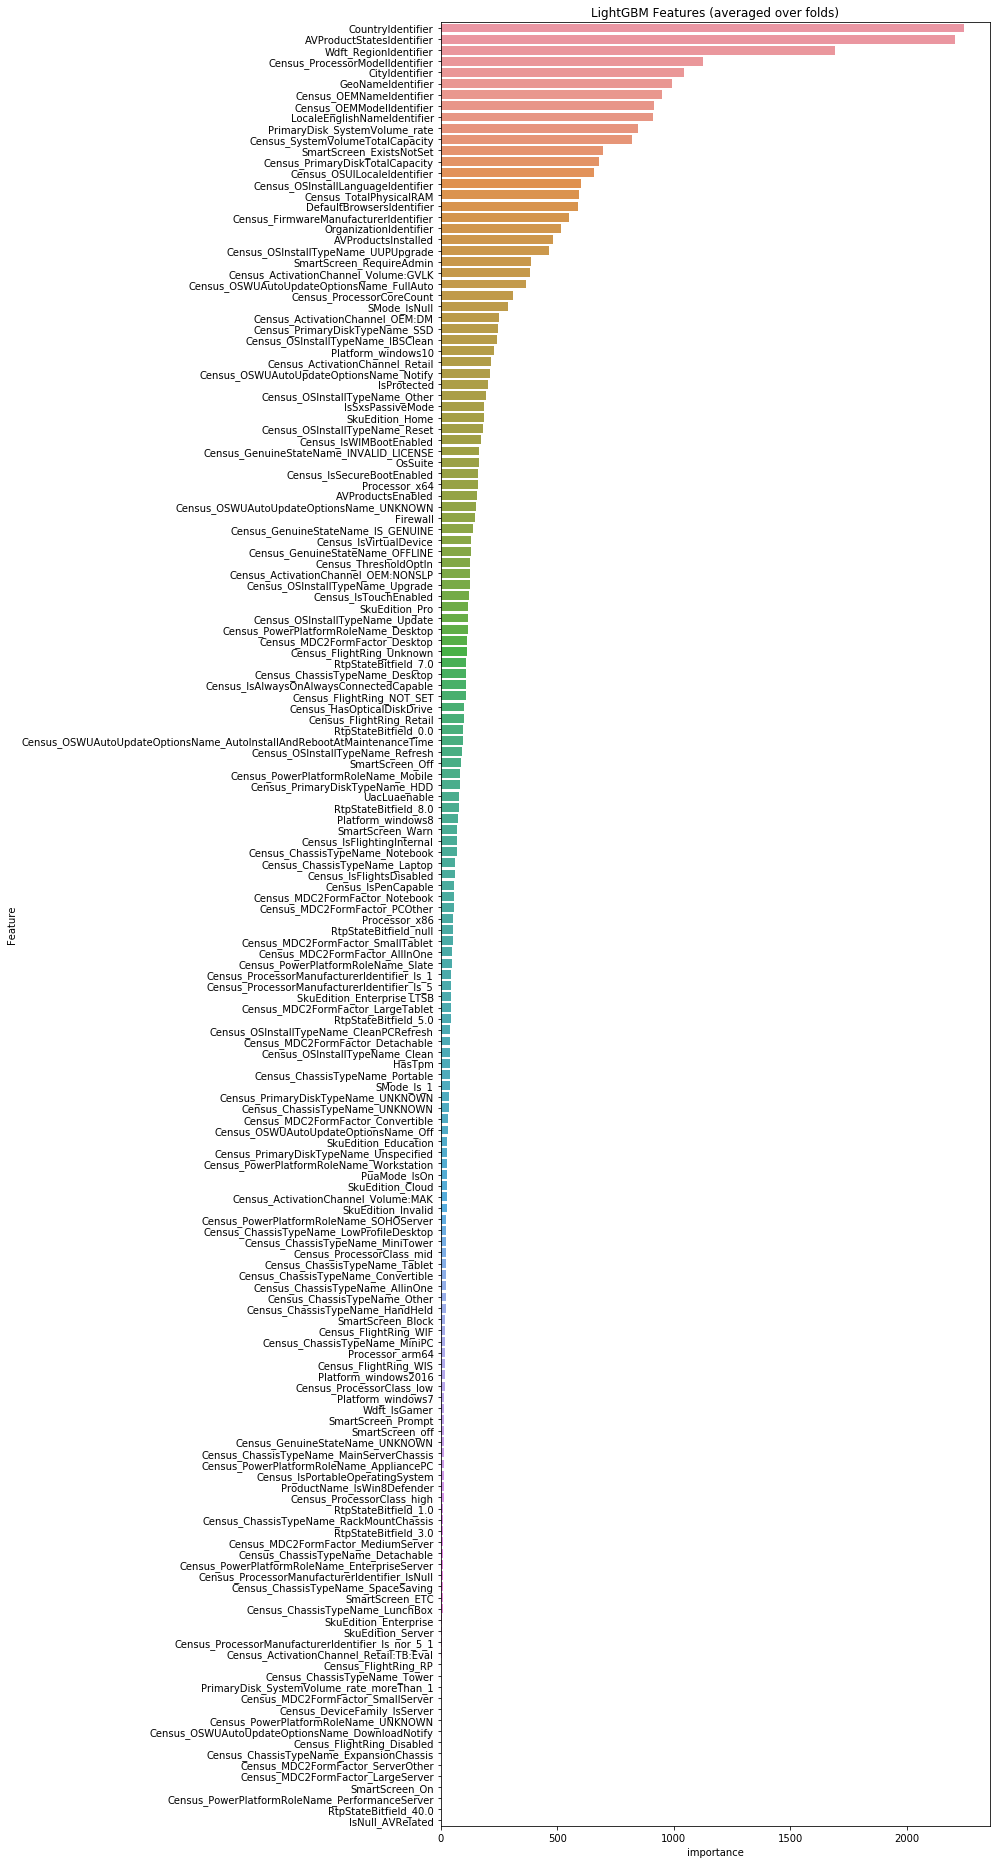

In [160]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [141]:
submission.set_index('MachineIdentifier').corr()

,HasDetections,NewDetections
HasDetections,1.00000,0.94027
NewDetections,0.94027,1.00000


In [143]:
submission = pd.read_csv('./data/sample_submission.csv')

In [145]:
submission.HasDetections = lgb_test_result / counter

In [146]:
submission.head(3)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.593827
1,00000176ac758d54827acd545b6315a5,0.539518
2,0000019dcefc128c2d4387c1273dae1d,0.335664


In [147]:
submission.to_csv('./data/sub_lgb_base_label_to_freq_cv_0.712343.csv', index=False)

In [ ]:
param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'max_depth': -1,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'min_sum_hessian_in_leaf': 0.0025,
        'max_bin': 120,
        'lambda_l1': 5,
        'lambda_l2': 2,
        'min_gain_to_split': 0.65,
        'save_binary': True,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': 0.05,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'verbose': 1,
        'metric': 'auc'
    }

In [ ]:
max_depth=-1,
n_estimators=1000,
learning_rate=0.1,
num_leaves=2**5-1,
objective='binary', 
boosting_type='gbdt',
save_binary=True,
feature_fraction=0.8,
feature_fraction_seed=42,
n_jobs=-1